# Spam email filter using machine learning
In this notebook, we will try to develop a machine learning model that is able to classify an email as spam or not-spam. This problem combines two aspects of machine learning techniques: Natural Language Processing and Classification (binary in this case).

<img src="spam-yahoo-mail.jpg" width="300px">

We will use two NLP approaches to vectorize the emails (email text --> numerical vector) and two machine learning algorithms (Support Vector Machine and Neural Network) 

**Import section**

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from html.parser import HTMLParser
import re
import os
import nltk
nltk.download('words')
nltk.download('punkt')
from nltk.corpus import words
from nltk.tokenize import word_tokenize
import pickle
from sklearn.svm import SVR, SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from gensim.models.word2vec import Word2Vec
from tqdm import tqdm 
import re
import gc
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
import keras

[nltk_data] Downloading package words to /home/mrrob0t/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to /home/mrrob0t/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Using TensorFlow backend.


## Helper functions
Here we define some useful functions that will help us process the data.

In [5]:
# Extends HTMLParser to adapt it to our data
class HtmlHrefParser(HTMLParser):
    def __init__(self):
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.fed = []
    def handle_data(self, d):
        self.fed.append(d)
    def handle_starttag(self, tag, attrs):
        if(tag=='a'):
            for (att, val) in attrs:
                if (att=='href'):
                    self.fed.append(' hreflink ')
    def get_data(self):
        return ''.join(self.fed)

def strip_tags(html):
    """Uses the HtmlHrefParser class to format the email text"""
    s = HtmlHrefParser()
    s.feed(html)
    return s.get_data()

# Words in the english language
word_list = list(set(words.words()))
    
def read_email(filename):
    """Reads the data from a file, strips the tags using 'strip_tags' function, and returns the email text and the email vocabulary tokens"""
    vocab = []
    with open(filename, 'r') as File:  
        try:
            email = re.sub(r'[^a-zA-Z]', ' ', strip_tags(re.sub(r'http\S+', ' hreflink ', File.read()))).strip().lower()
            # consider only words from the english dictionary 
            for word in word_tokenize(email):
                if (len(word) >= 2) and (word in word_list):
                    vocab.append(word)
            return email, vocab
        except UnicodeDecodeError:
            print('couldnt read {}'.format(filename))
            return None, vocab

In [6]:
LIMIT = None # limit of the samples we read from data folders

In [7]:
def read_from_dir(path, label=None):
    """Reads data from a directory using 'read_email' and returns the corpus, the corpus in tokenized format, the vocabulary of the corpus and the list of labels corresponding to each entry in the corpus """
    corpus = []
    vocabulary = []
    corpus_tokenized = []
    count = 0
    labels = []
    files = os.listdir(path)
    if (LIMIT is not None):
        max_idx = len(files) if len(files)<LIMIT else LIMIT
        files = files[:max_idx]
    for filename in tqdm(files):
        if (LIMIT is not None) and (count > LIMIT):
            break

        em, v = read_email(path+filename)

        if (em is None):
            continue
            
        if(label is not None):
            labels.append(label)

        corpus.append(em)
        corpus_tokenized.append(v)
        count += 1
        
        if(label):
            vocabulary = vocabulary + v

    return corpus, corpus_tokenized, vocabulary, labels

## Reading Data
In this part, we will read the training and testing data from the folders. We have three folders:
* **training**: Containing spam and non-spam (ham) data, with a mix of text difficulties. This will be used for training
* **cross_validation** and **testing**: Containing spam and non-spam (ham) data for testing (both have different levels of difficulties)

In [5]:
corpus = []
corpus_tokenized = []
vocabulary = []
    
start = time.time()

spam_train_path = './training/spam/'
corpus, corpus_tokenized, vocabulary, labels = read_from_dir(spam_train_path,1)
    
    
ham_train_path = './training/ham/'
c, ct, v, lbls = read_from_dir(ham_train_path,0)
corpus = corpus + c
corpus_tokenized = corpus_tokenized + ct
vocabulary = vocabulary + v
labels = labels + lbls

end = time.time()
print('done in %.2f s' % (end - start))

  1%|          | 9/1397 [00:29<1:11:51,  3.11s/it]

couldnt read ./training/spam/00680.e8df67f239cb166c5a8a78401eeeb1ba


  2%|▏         | 21/1397 [01:10<1:16:40,  3.34s/it]

couldnt read ./training/spam/00699.46c52d8e3b9db13ea2e9816f1c919961


  2%|▏         | 23/1397 [01:12<1:00:00,  2.62s/it]

couldnt read ./training/spam/01125.46ca779f86e1dd0a03c3ffc67b57f55e


  3%|▎         | 37/1397 [01:52<1:22:18,  3.63s/it]

couldnt read ./training/spam/00122.4a2f67839c81141a1075745a66c907bb


  3%|▎         | 45/1397 [02:17<1:14:12,  3.29s/it]

couldnt read ./training/spam/00708.89f1f9108884517148fdbd744e18ec1e


  4%|▍         | 58/1397 [04:14<1:40:57,  4.52s/it] 

couldnt read ./training/spam/00006.3ca1f399ccda5d897fecb8c57669a283


  5%|▍         | 67/1397 [04:38<1:02:36,  2.82s/it]

couldnt read ./training/spam/00492.3052cad36d423e60195ce706c7bc0e6f


  8%|▊         | 110/1397 [07:23<53:56,  2.51s/it]  

couldnt read ./training/spam/00228.238a0547cbbd70a024d7d4376707f201


  8%|▊         | 114/1397 [07:38<1:49:47,  5.13s/it]

couldnt read ./training/spam/00588.44b644374b89ba4885f91f0ed836e622


 10%|▉         | 134/1397 [08:48<1:20:42,  3.83s/it]

couldnt read ./training/spam/00886.9bd2063c3d984a66958a6195ffb97849


 10%|▉         | 137/1397 [09:08<1:34:52,  4.52s/it]

couldnt read ./training/spam/00683.41038a20d4763e8042a811a03612bae4


 10%|█         | 144/1397 [09:26<1:04:15,  3.08s/it]

couldnt read ./training/spam/00069.27497d5d2f92837805b67e2bf31dfc71


 12%|█▏        | 165/1397 [10:30<1:21:57,  3.99s/it]

couldnt read ./training/spam/01144.94d2d4f5dfefab34c1370aec38d470eb


 13%|█▎        | 184/1397 [11:21<52:15,  2.58s/it]  

couldnt read ./training/spam/00642.f213f657ab630999a8d34c26060d79fc
couldnt read ./training/spam/01259.b4dff1ed93bc931b271888cd42e41b85


 19%|█▉        | 269/1397 [16:31<48:40,  2.59s/it]  

couldnt read ./training/spam/00748.2b1fcd8621caf857e9ec0b08555ae5db


 19%|█▉        | 271/1397 [16:36<46:00,  2.45s/it]

couldnt read ./training/spam/00374.b174d1e94449f519f3ceba87e7cefea7
couldnt read ./training/spam/01060.d72413ea3af9e1c5530a3570e0bb517e


 21%|██▏       | 298/1397 [17:47<1:01:27,  3.36s/it]

couldnt read ./training/spam/01173.e0da19fcbb5649aa5104320ce38c6906


 22%|██▏       | 308/1397 [18:47<1:40:37,  5.54s/it]

couldnt read ./training/spam/01072.ac604802c74de2ebc445efc827299b96


 23%|██▎       | 318/1397 [19:15<47:24,  2.64s/it]  

couldnt read ./training/spam/00243.2fa7ea5c308d2d572c7e8efc679bb6a9


 23%|██▎       | 324/1397 [19:29<41:30,  2.32s/it]

couldnt read ./training/spam/00140.f690cb156c0b1223e763ab3c0b340c57


 24%|██▎       | 330/1397 [20:25<1:51:34,  6.27s/it]

couldnt read ./training/spam/01379.0d39498608cd170bbbc8cd33ffd18e35


 27%|██▋       | 372/1397 [22:42<2:00:38,  7.06s/it]

couldnt read ./training/spam/00395.74aee42fac915ca758047506ec59a21f


 27%|██▋       | 377/1397 [22:54<1:19:18,  4.67s/it]

couldnt read ./training/spam/00329.47e3728483bdcad34227e601eb348836


 27%|██▋       | 382/1397 [23:16<1:34:21,  5.58s/it]

couldnt read ./training/spam/00412.2498d35d4ac806f77e31a17839d5c4c2


 28%|██▊       | 388/1397 [23:26<48:27,  2.88s/it]  

couldnt read ./training/spam/00909.be44baf9966a96b2154b207cc56fe558


 29%|██▉       | 407/1397 [24:45<1:26:23,  5.24s/it]

couldnt read ./training/spam/00013.372ec9dc663418ca71f7d880a76f117a


 30%|██▉       | 417/1397 [26:04<2:51:11, 10.48s/it]

couldnt read ./training/spam/00743.7889a6b188891a33c088f3d29d48251a


 31%|███       | 431/1397 [26:50<56:30,  3.51s/it]  

couldnt read ./training/spam/00028.60393e49c90f750226bee6381eb3e69d


 31%|███       | 434/1397 [26:56<51:02,  3.18s/it]

couldnt read ./training/spam/00271.7105f4998a88cbf4036403f61ba60d65


 32%|███▏      | 442/1397 [27:20<46:04,  2.90s/it]  

couldnt read ./training/spam/00554.c325ab7400fb7e3f053ed0cac4ed7545


 33%|███▎      | 462/1397 [28:20<27:41,  1.78s/it]  

couldnt read ./training/spam/01233.010677fced50f4aecb67fba70701bcf5


 33%|███▎      | 467/1397 [29:52<5:08:20, 19.89s/it]

couldnt read ./training/spam/01260.fae84d2193ed2d65a14e2c8b612fb7fe
couldnt read ./training/spam/00741.00c61b5577b6fa232434c2ae62d52394


 34%|███▍      | 480/1397 [30:25<59:44,  3.91s/it]  

couldnt read ./training/spam/00081.4c7fbdca38b8def54e276e75ec56682e


 35%|███▌      | 495/1397 [31:12<45:26,  3.02s/it]  

couldnt read ./training/spam/00246.d314e68151f961425104dbe6a4e3bc9a


 37%|███▋      | 512/1397 [31:54<34:00,  2.31s/it]

couldnt read ./training/spam/00037.c7f0ce13d4cad8202f3d1a02b5cc5a1d


 38%|███▊      | 528/1397 [32:34<51:03,  3.53s/it]

couldnt read ./training/spam/01261.0d7a6fa74b73f80f62fe11267eeaa956


 38%|███▊      | 531/1397 [32:38<35:41,  2.47s/it]

couldnt read ./training/spam/00750.dfc392478300e11189d61d29bed9cecc


 39%|███▉      | 547/1397 [33:40<57:56,  4.09s/it]  

couldnt read ./training/spam/01376.73e738e4cd8121ce3dfb42d190b193c9


 40%|███▉      | 557/1397 [34:09<1:03:32,  4.54s/it]

couldnt read ./training/spam/00692.e886bd6ece727e1c1fdbae4dc4b60bb5


 41%|████      | 573/1397 [34:50<28:57,  2.11s/it]  

couldnt read ./training/spam/01105.2582a4afba9b0b06bed5d48e3e8b29df


 44%|████▍     | 621/1397 [39:13<1:47:12,  8.29s/it]

couldnt read ./training/spam/00328.47ba83d868220761b2ff71ce39d91a37


 45%|████▌     | 632/1397 [39:38<33:45,  2.65s/it]  

couldnt read ./training/spam/01353.369f79f8f31f3b18bdb5d1006207b52e


 46%|████▌     | 642/1397 [40:12<50:50,  4.04s/it]

couldnt read ./training/spam/01107.5b3ad5e88347b08967ec627b815f2fc3
couldnt read ./training/spam/00252.3b352c8a7266026be4f1c1ba89690cfc


 47%|████▋     | 653/1397 [41:09<1:34:46,  7.64s/it]

couldnt read ./training/spam/00472.3c51cf86307bc98c54d856887a81e9ac


 47%|████▋     | 661/1397 [41:36<42:58,  3.50s/it]  

couldnt read ./training/spam/00018.336cb9e7b0358594cf002e7bf669eaf5


 48%|████▊     | 677/1397 [42:19<41:23,  3.45s/it]

couldnt read ./training/spam/01399.2319643317e2c5193d574e40a71809c2


 49%|████▉     | 691/1397 [43:05<33:58,  2.89s/it]  

couldnt read ./training/spam/00742.2700b00dc2dcc121ee0a1322040de188
couldnt read ./training/spam/00261.e679a9947bd481d47fb1a3d83b482fd5


 50%|█████     | 700/1397 [44:05<1:01:51,  5.32s/it]

couldnt read ./training/spam/01064.50715ffeb13446500895836b77fcee09


 50%|█████     | 702/1397 [44:07<46:32,  4.02s/it]  

couldnt read ./training/spam/00921.548fb6dd2244c2fe87079df9652ddc2c
couldnt read ./training/spam/00609.4dfe7912017772587dc62fecc3cf6553


 52%|█████▏    | 720/1397 [45:00<28:07,  2.49s/it]

couldnt read ./training/spam/00136.870132877ae18f6129c09da3a4d077af


 52%|█████▏    | 733/1397 [45:39<39:11,  3.54s/it]

couldnt read ./training/spam/01167.2ac57a0189fa2b8713202b84e587b707


 53%|█████▎    | 736/1397 [45:43<30:41,  2.79s/it]

couldnt read ./training/spam/00139.cee7452bc16a8e26ea1ad841321c95ce


 54%|█████▍    | 751/1397 [46:18<24:38,  2.29s/it]

couldnt read ./training/spam/00951.f7044a1b178dc3dcff44932f840b8805


 54%|█████▍    | 757/1397 [46:29<20:29,  1.92s/it]

couldnt read ./training/spam/01106.37f316c0f77e739cb5fe0e37aaea2046


 55%|█████▌    | 771/1397 [48:01<1:08:13,  6.54s/it]

couldnt read ./training/spam/01235.2e8191ab7ddffa2290e04f9ce0422041


 57%|█████▋    | 802/1397 [49:43<36:43,  3.70s/it]  

couldnt read ./training/spam/01013.c6cf4f54eda63230389baccc02702034
couldnt read ./training/spam/01268.626ef5e5fa30314816e0f049ea03bd9f


 59%|█████▉    | 823/1397 [50:38<31:34,  3.30s/it]

couldnt read ./training/spam/01017.11a80131a2ae31ad0a9969189de3c2bb


 59%|█████▉    | 827/1397 [50:52<30:42,  3.23s/it]

couldnt read ./training/spam/01314.12c8b5b91bc690f0f0d6fad595150ac6


 59%|█████▉    | 831/1397 [51:02<30:36,  3.24s/it]

couldnt read ./training/spam/01246.d0ee9c7ebf9d953b21de9414cc96c2f9


 61%|██████    | 852/1397 [52:13<34:43,  3.82s/it]  

couldnt read ./training/spam/00316.6127940652124130611907ee0c20ab5e


 62%|██████▏   | 861/1397 [53:13<1:11:09,  7.97s/it]

couldnt read ./training/spam/01338.a67c3827402b4610bd2a6814cd8cd907


 62%|██████▏   | 869/1397 [54:05<47:14,  5.37s/it]  

couldnt read ./training/spam/00789.ffe4e3c5dc50f5a9ac33a653b5f8b566


 63%|██████▎   | 875/1397 [54:21<31:49,  3.66s/it]

couldnt read ./training/spam/00421.540f120cafbc8a068fcc7f8a372a37b8


 63%|██████▎   | 881/1397 [54:33<21:49,  2.54s/it]

couldnt read ./training/spam/01301.91269fd2b14a1fa0f183ca60953b99af


 65%|██████▌   | 914/1397 [56:31<25:17,  3.14s/it]  

couldnt read ./training/spam/00808.c072069806eb82f9aaf8d21d39789ea6


 66%|██████▌   | 916/1397 [56:33<20:08,  2.51s/it]

couldnt read ./training/spam/00452.f13574a4582c94daf2bd6668c1683eed


 66%|██████▌   | 918/1397 [56:35<16:00,  2.00s/it]

couldnt read ./training/spam/00737.af5f503fe444ae773bfeb4652d122349


 66%|██████▋   | 927/1397 [57:08<20:51,  2.66s/it]

couldnt read ./training/spam/00464.d2f719c667d192af860572b1c858cc11


 66%|██████▋   | 929/1397 [57:24<32:51,  4.21s/it]

couldnt read ./training/spam/01227.04a4f94c7a73b29cb56bf38c7d526116


 67%|██████▋   | 932/1397 [57:29<22:52,  2.95s/it]

couldnt read ./training/spam/01221.baf498fd213b8bc77b9dbfb13c1a6968


 69%|██████▉   | 963/1397 [1:00:02<33:26,  4.62s/it]

couldnt read ./training/spam/00853.ee1fe2f2d16e8b27be79a670b8597252


 69%|██████▉   | 966/1397 [1:00:08<24:14,  3.38s/it]

couldnt read ./training/spam/00556.098b57f5108ba34d21825f176e492786


 70%|██████▉   | 971/1397 [1:00:22<23:06,  3.25s/it]

couldnt read ./training/spam/00774.bb00990ae11efeabd677cc2935f2281f


 70%|██████▉   | 973/1397 [1:01:17<1:15:10, 10.64s/it]

couldnt read ./training/spam/00579.d94454f0e596c00bf22ce1f315427143


 71%|███████   | 986/1397 [1:01:52<22:53,  3.34s/it]  

couldnt read ./training/spam/01386.9398d616dfc3d67fb10e95d911768b39


 71%|███████   | 988/1397 [1:02:04<27:38,  4.06s/it]

couldnt read ./training/spam/00024.621bea2c6e0ebb2eb7ac00a38dfe6b00


 71%|███████   | 992/1397 [1:02:13<19:22,  2.87s/it]

couldnt read ./training/spam/00311.176626eb0ec0de8f451a079083104975


 73%|███████▎  | 1026/1397 [1:04:21<19:10,  3.10s/it]  

couldnt read ./training/spam/00695.f79afe1f94217d0a2e6f983caf011b49


 74%|███████▎  | 1029/1397 [1:04:26<14:20,  2.34s/it]

couldnt read ./training/spam/00704.30306e2e506ca198fe8dea2b3c11346a


 75%|███████▍  | 1047/1397 [1:06:29<22:12,  3.81s/it]  

couldnt read ./training/spam/00359.90bec90ebeaf05f024f48594e7d7b0d5


 76%|███████▌  | 1057/1397 [1:07:00<24:15,  4.28s/it]

couldnt read ./training/spam/00528.a7b02c9abd9fb303615a956bbc4af548


 76%|███████▌  | 1063/1397 [1:07:14<13:19,  2.39s/it]

couldnt read ./training/spam/00960.ae114c0b717c866b821efe032780a8e5


 76%|███████▌  | 1065/1397 [1:07:18<12:07,  2.19s/it]

couldnt read ./training/spam/00706.5116018237368c3633823b2d24f8ac86
couldnt read ./training/spam/00117.9f0ba9c35b1fe59307e32b7c2c0d4e61


 77%|███████▋  | 1077/1397 [1:07:59<13:27,  2.52s/it]

couldnt read ./training/spam/00145.b6788a48c1eace0b7c34ff7de32766f6


 77%|███████▋  | 1080/1397 [1:08:02<10:31,  1.99s/it]

couldnt read ./training/spam/00214.39bd955c9db013255c326dbcbb4f2f86


 79%|███████▊  | 1097/1397 [1:08:43<11:44,  2.35s/it]

couldnt read ./training/spam/00876.f61ec69c2872eb398ba3860a13a17b15


 79%|███████▊  | 1099/1397 [1:08:46<11:03,  2.23s/it]

couldnt read ./training/spam/00397.dc85d97361fbed3637f8db56d4c9c92d


 81%|████████  | 1128/1397 [1:10:42<24:34,  5.48s/it]

couldnt read ./training/spam/00319.2702ee4100f722328afc52a1a6f1dc26


 82%|████████▏ | 1140/1397 [1:11:26<10:18,  2.41s/it]

couldnt read ./training/spam/01065.9ecef01b01ca912fa35453196b4dae4c
couldnt read ./training/spam/01104.ec267abf01fe81c42dc90dfd16c930bc


 82%|████████▏ | 1147/1397 [1:11:49<15:57,  3.83s/it]

couldnt read ./training/spam/01164.55202a4234914b20004dc7f9264313e5


 83%|████████▎ | 1156/1397 [1:12:17<13:16,  3.31s/it]

couldnt read ./training/spam/00025.9054470cb5193db2955a4d4a003698d6


 84%|████████▎ | 1168/1397 [1:13:08<10:55,  2.86s/it]

couldnt read ./training/spam/00043.9331daf0bd865aa657cb02cbcd06173b


 84%|████████▍ | 1170/1397 [1:13:10<08:44,  2.31s/it]

couldnt read ./training/spam/00040.d9570705b90532c2702859569bf4d01c


 84%|████████▍ | 1174/1397 [1:13:24<12:39,  3.41s/it]

couldnt read ./training/spam/00138.acef24ad51f98e3192d5a0348543f02f


 85%|████████▍ | 1187/1397 [1:14:05<08:09,  2.33s/it]

couldnt read ./training/spam/01217.d5a1734ec521c1bd55270eca3ab4acd8


 85%|████████▌ | 1193/1397 [1:14:22<11:21,  3.34s/it]

couldnt read ./training/spam/01120.853b87a34ab28efd22d9851702b2f9c5


 86%|████████▌ | 1196/1397 [1:14:49<17:55,  5.35s/it]

couldnt read ./training/spam/00475.3d497c7d96c51986316db566756ff35a


 86%|████████▌ | 1198/1397 [1:14:52<13:48,  4.16s/it]

couldnt read ./training/spam/00670.a3175dd0b4a1e1a26822c5fee6d6837b


 90%|█████████ | 1262/1397 [1:20:07<04:13,  1.88s/it]  

couldnt read ./training/spam/00368.64d7f78532bf9b4cd41c8f5bc526af6a


 91%|█████████ | 1267/1397 [1:20:28<09:43,  4.49s/it]

couldnt read ./training/spam/00044.9f8c4b9ae007c6ded3d57476082bf2b2


 91%|█████████ | 1269/1397 [1:20:31<07:39,  3.59s/it]

couldnt read ./training/spam/00274.192bd3848a65302344dff2d7c0d3f08a


 91%|█████████ | 1273/1397 [1:20:38<05:23,  2.61s/it]

couldnt read ./training/spam/00253.bd8e0dd85f0f848be89aadbf6d6364dc


 92%|█████████▏| 1288/1397 [1:21:18<03:35,  1.97s/it]

couldnt read ./training/spam/01170.0f6cbb8149f3e19d1b3054960e2cceb5


 92%|█████████▏| 1290/1397 [1:21:23<03:51,  2.16s/it]

couldnt read ./training/spam/00580.c3b23134b4767f5e796d0df997fede33
couldnt read ./training/spam/00427.c3d316b9e7fefe87329d31b09c1601fe


 93%|█████████▎| 1299/1397 [1:21:58<05:57,  3.65s/it]

couldnt read ./training/spam/00471.df77fa930951f79466c195052ff56816


 95%|█████████▍| 1323/1397 [1:23:11<03:00,  2.44s/it]

couldnt read ./training/spam/00905.8dcb590481d3e3c04d03506100c59497


 95%|█████████▍| 1327/1397 [1:23:17<02:16,  1.95s/it]

couldnt read ./training/spam/00207.47d129a97b8ce8572c9efb4c18a74192
couldnt read ./training/spam/00645.dd7d8ec1eb687c5966c516b720fcc3d5


 98%|█████████▊| 1368/1397 [1:26:28<01:33,  3.23s/it]

couldnt read ./training/spam/00239.91d2d5c0e8827c4a42cb24733a0859fa


 98%|█████████▊| 1373/1397 [1:27:03<03:03,  7.66s/it]

couldnt read ./training/spam/00135.9996d6845094dcec94b55eb1a828c7c4


100%|█████████▉| 1395/1397 [1:28:21<00:08,  4.09s/it]

couldnt read ./training/spam/00468.fb2222cc49228bd3dac5481e670f208f


  0%|          | 4/1611 [00:16<1:45:48,  3.95s/it]

couldnt read ./training/ham/0282.fd87e7b9765004f6123ebe981bc16a1c


  2%|▏         | 26/1611 [01:39<1:54:10,  4.32s/it]

couldnt read ./training/ham/1365.83f365382e725776956f137a4600117e


  2%|▏         | 35/1611 [02:11<1:40:53,  3.84s/it]

couldnt read ./training/ham/1238.af17c6dc01076c3f5fd80b0aaf13b70a


  6%|▌         | 93/1611 [05:54<1:28:02,  3.48s/it]

couldnt read ./training/ham/1119.ce22f4a2ffbc03cd2625cb10ba561058


  7%|▋         | 114/1611 [07:17<1:29:57,  3.61s/it]

couldnt read ./training/ham/0207.f7d2d40df256d6caea05314f5334a959


 10%|█         | 163/1611 [10:16<1:15:51,  3.14s/it]

couldnt read ./training/ham/1131.7f31a18433046205b44e6b46f9677f9a


 10%|█         | 169/1611 [10:37<1:39:12,  4.13s/it]

couldnt read ./training/ham/0267.218a528c448166d39f853cf75d8890dd


 11%|█         | 172/1611 [10:48<1:41:25,  4.23s/it]

couldnt read ./training/ham/0156.3d3293a5da919cf65959e6bd63feaf27


 11%|█▏        | 184/1611 [11:28<1:10:02,  2.95s/it]

couldnt read ./training/ham/1398.02fd0caad73d10ee02aebd13b761f135


 13%|█▎        | 203/1611 [12:28<1:17:05,  3.29s/it]

couldnt read ./training/ham/0146.2d301a1e07672538d669f5e571180d32


 13%|█▎        | 207/1611 [12:35<1:01:27,  2.63s/it]

couldnt read ./training/ham/0269.5a74b38284c7e9d85338eca0a25cb191


 14%|█▍        | 229/1611 [13:51<1:21:50,  3.55s/it]

couldnt read ./training/ham/1010.1bc4545387a6a526b351a330b4aca16c


 17%|█▋        | 266/1611 [16:33<1:48:14,  4.83s/it]

couldnt read ./training/ham/0857.c5290c6dee60d45314e519678e96735c


 17%|█▋        | 272/1611 [16:50<1:18:53,  3.53s/it]

couldnt read ./training/ham/0591.f533bea095d75cc4dc282bdcba69072a


 17%|█▋        | 280/1611 [17:21<1:38:48,  4.45s/it]

couldnt read ./training/ham/0799.eb9fe164fe9541253b4ab806626ab171


 18%|█▊        | 287/1611 [17:46<1:39:33,  4.51s/it]

couldnt read ./training/ham/1322.7faaa22a10e2eab022719a868f587686


 19%|█▊        | 301/1611 [18:37<1:23:02,  3.80s/it]

couldnt read ./training/ham/0638.70122b70a334560fdbc450b6516bf752


 22%|██▏       | 355/1611 [22:13<1:37:08,  4.64s/it]

couldnt read ./training/ham/0551.5bdfb0c299c60e442e39346dc08bad68


 24%|██▍       | 392/1611 [24:21<1:05:39,  3.23s/it]

couldnt read ./training/ham/0550.8e86f9859287ac9846e3c179b29e0fc1


 24%|██▍       | 394/1611 [24:26<1:00:44,  2.99s/it]

couldnt read ./training/ham/1117.571c1399a9b49bf25062fcd2242d72f1


 26%|██▋       | 424/1611 [26:39<2:04:16,  6.28s/it]

couldnt read ./training/ham/0027.11da06d9130a188bf0ffb2060881dbe9


 28%|██▊       | 454/1611 [28:31<59:35,  3.09s/it]  

couldnt read ./training/ham/0549.59f3057eef31f2b8ebb02446556a3f37


 28%|██▊       | 458/1611 [28:40<52:19,  2.72s/it]

couldnt read ./training/ham/1166.8a9dbee6ac67226f58a80c0993a700e2


 30%|██▉       | 481/1611 [30:11<1:22:15,  4.37s/it]

couldnt read ./training/ham/0457.dc1691cbb334cc33a1f1eb3060b8e02e


 30%|███       | 487/1611 [30:29<1:08:26,  3.65s/it]

couldnt read ./training/ham/1014.8262a256b8f2e481dcae966b0c5088e8


 32%|███▏      | 515/1611 [32:06<1:08:54,  3.77s/it]

couldnt read ./training/ham/0080.7c3a836baaa732cd915546442c0fef1a


 32%|███▏      | 521/1611 [32:27<1:16:26,  4.21s/it]

couldnt read ./training/ham/1444.9c769de9af58bfba4b3e6b0ca034f2b8


 37%|███▋      | 596/1611 [37:27<1:05:07,  3.85s/it]

couldnt read ./training/ham/1429.3c60313af6a2a5c79bb97e06855a4af7


 37%|███▋      | 598/1611 [37:32<57:05,  3.38s/it]  

couldnt read ./training/ham/0202.e1c7980f6c8a70122d80771533795cb7


 38%|███▊      | 617/1611 [38:46<1:04:56,  3.92s/it]

couldnt read ./training/ham/0178.8405bbe39a5eb6c1814e3c16602099a4


 39%|███▉      | 629/1611 [39:33<1:04:21,  3.93s/it]

couldnt read ./training/ham/0238.7b9b9b2e3b3ca24ae8960f03aab57964


 40%|███▉      | 644/1611 [40:21<57:06,  3.54s/it]  

couldnt read ./training/ham/1121.51f7e5e557bde451a6b36e527211ed04


 41%|████      | 657/1611 [42:35<1:13:40,  4.63s/it]

couldnt read ./training/ham/1452.81f3e3d1b40f978cd3c0125e7020dd17


 42%|████▏     | 675/1611 [43:44<1:03:42,  4.08s/it]

couldnt read ./training/ham/0289.cb9c0595bddae2c25357ce5c9fbaf687


 43%|████▎     | 687/1611 [44:30<1:05:56,  4.28s/it]

couldnt read ./training/ham/1193.8805a7218e81db9893ee2b704d9ebeb1


 44%|████▍     | 707/1611 [45:42<58:17,  3.87s/it]  

couldnt read ./training/ham/0264.a1183a59e4f0a71e80378d9404a3212f


 45%|████▍     | 717/1611 [46:16<52:34,  3.53s/it]  

couldnt read ./training/ham/0652.5ed46908836bacba742b337197ce3499


 45%|████▍     | 720/1611 [46:26<51:30,  3.47s/it]

couldnt read ./training/ham/0402.a511fb74deca95f59d4eff5daa45a9b8


 45%|████▌     | 725/1611 [46:37<41:14,  2.79s/it]

couldnt read ./training/ham/1303.b8fb03a2de8615f9287086ccc71a4282


 45%|████▌     | 727/1611 [46:40<35:24,  2.40s/it]

couldnt read ./training/ham/0704.f62f0ee295a7f648249c8104a8e45843


 46%|████▌     | 742/1611 [47:40<1:09:23,  4.79s/it]

couldnt read ./training/ham/1124.ca18e9fe0618bbac33ef2156d047cc7d


 47%|████▋     | 758/1611 [48:36<51:04,  3.59s/it]  

couldnt read ./training/ham/0239.58f51c99b02fc8b49664f15a855af780


 47%|████▋     | 762/1611 [48:46<45:59,  3.25s/it]

couldnt read ./training/ham/0640.95f677f7c53a182c30e068eaab74950e


 48%|████▊     | 780/1611 [49:53<56:06,  4.05s/it]  

couldnt read ./training/ham/0225.80a615200726ed2da1bfd347dcfd648c


 49%|████▊     | 784/1611 [50:03<41:31,  3.01s/it]

couldnt read ./training/ham/0226.aafb7854f8f17e90f7e5e5f99c54e76e


 50%|█████     | 810/1611 [51:45<53:54,  4.04s/it]  

couldnt read ./training/ham/0228.b83f2f4ef114c69d9ca927d1082b393f


 51%|█████     | 815/1611 [52:01<49:46,  3.75s/it]

couldnt read ./training/ham/0469.8b40f778677e8d001ca14bcc4268b41b


 51%|█████▏    | 826/1611 [52:39<52:20,  4.00s/it]

couldnt read ./training/ham/0615.935b5a30e35ec46502a33a445443c124


 51%|█████▏    | 829/1611 [52:45<42:25,  3.26s/it]

couldnt read ./training/ham/0208.0577aa26cbb2382d8789377d351ca8bf


 52%|█████▏    | 840/1611 [53:15<33:15,  2.59s/it]

couldnt read ./training/ham/1013.8355d120301841c6b601bee02bb4c14f


 54%|█████▎    | 862/1611 [54:42<59:56,  4.80s/it]  

couldnt read ./training/ham/1022.73ab70b91862d709897cfe3dd5bb22a0


 55%|█████▍    | 882/1611 [55:50<51:39,  4.25s/it]

couldnt read ./training/ham/0461.7609029b07acf65f40bd93882aa35887


 55%|█████▌    | 889/1611 [56:10<38:23,  3.19s/it]

couldnt read ./training/ham/0326.703aa5be82f6586d348723b732176418


 56%|█████▌    | 901/1611 [56:48<35:56,  3.04s/it]

couldnt read ./training/ham/1340.763507dad3b921f972640d4d76172f7e


 56%|█████▌    | 903/1611 [56:49<25:38,  2.17s/it]

couldnt read ./training/ham/0806.2eae7f9f133274ed400a215174b7de1d


 57%|█████▋    | 916/1611 [57:37<38:30,  3.32s/it]

couldnt read ./training/ham/1163.3ad31ba9c55ae030d3d708b5987f889e


 58%|█████▊    | 927/1611 [58:15<45:55,  4.03s/it]

couldnt read ./training/ham/0589.8646984ed76a8df2811750d151f56b1e


 58%|█████▊    | 929/1611 [58:20<40:34,  3.57s/it]

couldnt read ./training/ham/0627.c9ad8730dad7bda1e1169ee00c4006fc


 59%|█████▉    | 950/1611 [59:44<35:27,  3.22s/it]

couldnt read ./training/ham/0673.1850e124a4ef3beb85071e67d7f8bf6d
couldnt read ./training/ham/1184.152999961bd0606fb0dcb6d6f95cc96d


 59%|█████▉    | 956/1611 [1:00:02<38:43,  3.55s/it]

couldnt read ./training/ham/0381.040644bb43a533c43f40361bd1d35355
couldnt read ./training/ham/0151.4d1c8772327e44b20af6420e1d1c0a75


 61%|██████    | 985/1611 [1:01:41<38:58,  3.74s/it]

couldnt read ./training/ham/0268.77ef28e27a9ee085646f260418072111


 62%|██████▏   | 997/1611 [1:02:24<39:01,  3.81s/it]

couldnt read ./training/ham/0357.1dbdc4d7a9e7e290455af62c1df78649


 62%|██████▏   | 999/1611 [1:02:26<31:05,  3.05s/it]

couldnt read ./training/ham/0205.84f75723dcf7639ed057a32283048bdf
couldnt read ./training/ham/1354.0cbd2821c28f742dfdcf33ffbfaeebac


 64%|██████▍   | 1029/1611 [1:04:22<36:42,  3.78s/it]  

couldnt read ./training/ham/0203.5f055220d95eaa1de71c7f24e004a7f5


 64%|██████▍   | 1032/1611 [1:04:28<30:12,  3.13s/it]

couldnt read ./training/ham/0320.6c54ea1bb991c6fae395588219cfce37


 65%|██████▍   | 1043/1611 [1:05:06<39:46,  4.20s/it]

couldnt read ./training/ham/0010.4996141de3f21e858c22f88231a9f463


 65%|██████▌   | 1050/1611 [1:05:33<37:27,  4.01s/it]

couldnt read ./training/ham/0300.2e30b3bffb4f2887df203c197d11e936
couldnt read ./training/ham/0423.353c3de8f5c7114179771f9b44e70b9e


 66%|██████▌   | 1056/1611 [1:05:46<31:44,  3.43s/it]

couldnt read ./training/ham/0977.d0e3f4e7fd0a8c2bdd26888af1ca3a0b


 66%|██████▋   | 1069/1611 [1:06:37<37:34,  4.16s/it]

couldnt read ./training/ham/1309.a63c188095d5f70604ec9c3a5f96ce0e


 66%|██████▋   | 1071/1611 [1:06:43<33:50,  3.76s/it]

couldnt read ./training/ham/1502.1376704c3bd9c110fe3a5d0768745d91


 68%|██████▊   | 1088/1611 [1:07:43<30:07,  3.46s/it]

couldnt read ./training/ham/1356.14e3ab9f37daa13ce7a15770017c4863


 68%|██████▊   | 1098/1611 [1:08:14<27:02,  3.16s/it]

couldnt read ./training/ham/0397.bdea17c7f90068a763d191914770f6d6


 69%|██████▊   | 1107/1611 [1:08:39<26:17,  3.13s/it]

couldnt read ./training/ham/1285.b9998969053e427bd4c4c0c6e68518ec


 69%|██████▉   | 1114/1611 [1:08:59<27:03,  3.27s/it]

couldnt read ./training/ham/0794.cf41a55933ae8896b668864d7b57b177


 73%|███████▎  | 1168/1611 [1:12:35<31:12,  4.23s/it]  

couldnt read ./training/ham/0321.b100345ae7b5e980f41d9c6e0ff3159a


 74%|███████▎  | 1188/1611 [1:13:48<27:07,  3.85s/it]

couldnt read ./training/ham/0196.0e960d0db312a26fade743e699ac5428


 75%|███████▍  | 1201/1611 [1:14:33<29:27,  4.31s/it]

couldnt read ./training/ham/1162.0ac7999a1814c6e79d6da0f6fb8ec301


 77%|███████▋  | 1236/1611 [1:16:50<19:11,  3.07s/it]

couldnt read ./training/ham/0773.e1edafa86a1670e9515d4d9c1bb288c9


 77%|███████▋  | 1244/1611 [1:17:21<27:10,  4.44s/it]

couldnt read ./training/ham/0287.18f9a821d67a503c0d54a2356a0f8a4a


 78%|███████▊  | 1259/1611 [1:18:13<20:56,  3.57s/it]

couldnt read ./training/ham/0495.5c4fb5aab57f610e00c4d3b951216f16


 79%|███████▉  | 1270/1611 [1:18:46<17:29,  3.08s/it]

couldnt read ./training/ham/0826.082e92a79a15aa7f6dd5b85a40327abd


 80%|███████▉  | 1283/1611 [1:19:37<17:40,  3.23s/it]

couldnt read ./training/ham/0795.6f8b4da0f06a9c055fc527562fe92330


 81%|████████  | 1302/1611 [1:22:18<2:42:21, 31.53s/it]

couldnt read ./training/ham/0656.dd2af7ab5d99adf717056893adb12a20


 85%|████████▌ | 1377/1611 [1:26:26<12:40,  3.25s/it]  

couldnt read ./training/ham/0891.44f5cad6f0dfa66277e1a0aec55e7bf6


 86%|████████▌ | 1379/1611 [1:26:30<10:40,  2.76s/it]

couldnt read ./training/ham/1360.18758d232e8b6937d5d62ce0e0aa2d8e


 86%|████████▌ | 1382/1611 [1:26:35<10:48,  2.83s/it]

couldnt read ./training/ham/1378.12eda7069e9d8a08ba37f0e4679f23ea


 87%|████████▋ | 1398/1611 [1:27:33<17:01,  4.80s/it]

couldnt read ./training/ham/0808.426e30e31a3d3fab634e31e8aeb30c34


 87%|████████▋ | 1400/1611 [1:27:35<13:02,  3.71s/it]

couldnt read ./training/ham/0240.01e0e10c03592e64df9a077f2cd56aba


 88%|████████▊ | 1410/1611 [1:28:14<12:53,  3.85s/it]

couldnt read ./training/ham/0611.4a47b06e83edee6c61ba37d1be2a09d0


 88%|████████▊ | 1421/1611 [1:28:53<12:07,  3.83s/it]

couldnt read ./training/ham/0008.20bc0b4ba2d99aae1c7098069f611a9b
couldnt read ./training/ham/0521.56b24a33e65cd045de37e6bec5ec30e3


 89%|████████▉ | 1432/1611 [1:29:26<10:52,  3.65s/it]

couldnt read ./training/ham/0297.738b9e94deb4bf077221292f071de345


 90%|████████▉ | 1447/1611 [1:30:15<09:33,  3.49s/it]

couldnt read ./training/ham/1015.f399ba43c22e3fdb1a22261714062cbd


 90%|█████████ | 1457/1611 [1:30:47<08:51,  3.45s/it]

couldnt read ./training/ham/0648.35cbc1bb7547966c1171f83d2312d4a9


 91%|█████████ | 1459/1611 [1:30:50<07:12,  2.84s/it]

couldnt read ./training/ham/0347.0e43f8ba3aadeed419f512188e5d8aa4


 91%|█████████▏| 1472/1611 [1:31:32<07:48,  3.37s/it]

couldnt read ./training/ham/1116.e30f22bbdea56cb1ba244a559564ddde


 92%|█████████▏| 1476/1611 [1:31:45<07:12,  3.21s/it]

couldnt read ./training/ham/1366.200cc41f250f28147c5db07ea933f26a


 95%|█████████▌| 1534/1611 [1:35:07<04:46,  3.73s/it]

couldnt read ./training/ham/0235.3c824d680d31b3710d8f3475730dc42d


 97%|█████████▋| 1562/1611 [1:37:11<02:59,  3.65s/it]

couldnt read ./training/ham/0222.160c5b2e2a80f71367b4d9a47f8f9d4e


 98%|█████████▊| 1577/1611 [1:38:07<02:00,  3.56s/it]

couldnt read ./training/ham/1383.4e6c2c19a9c9ff985a966f06ea87ed76


 98%|█████████▊| 1580/1611 [1:38:13<01:28,  2.85s/it]

couldnt read ./training/ham/0552.1ce63d212148c58723cc1f7150b27157


 98%|█████████▊| 1583/1611 [1:38:20<01:16,  2.74s/it]

couldnt read ./training/ham/1164.4f5726c74bd69e322849d54f54a646fe


 99%|█████████▊| 1588/1611 [1:38:37<01:24,  3.66s/it]

couldnt read ./training/ham/0526.615f918b4860d437577f6aa66c9b37cf


 99%|█████████▉| 1602/1611 [1:39:32<00:31,  3.46s/it]

couldnt read ./training/ham/1333.e9f5229e15c55a75e02a92fe42324bce


100%|██████████| 1611/1611 [1:39:55<00:00,  3.14s/it]

done in 11298.83 s


In [15]:
#labels = np.concatenate((np.ones(1276), np.zeros(1503)), axis=0)

In [19]:
# Cross-validation
ham_cv_corpus = []
spam_cv_corpus = []
ham_cv_path = './cross_validation/ham/'
spam_cv_path = './cross_validation/spam/'

# read ham cross-validation data
ham_cv_corpus, ham_cv_corpus_tokenized, v, lbls = read_from_dir(ham_cv_path)

# read spam cross-validation data
spam_cv_corpus, spam_cv_corpus_tokenized, v, lbls = read_from_dir(spam_cv_path)

  2%|▏         | 5/280 [00:07<05:52,  1.28s/it]

couldnt read ./cross_validation/ham/2407.c9318bb61b808a141780fa5067d53a05
couldnt read ./cross_validation/ham/2396.8126a8ee1ebb7fe484a5709f96192b02


  4%|▎         | 10/280 [00:11<06:04,  1.35s/it]

couldnt read ./cross_validation/ham/2419.104f029a2c2f3ddb0c756e7dd26501da


 11%|█         | 31/280 [00:43<05:48,  1.40s/it]

couldnt read ./cross_validation/ham/2483.9eb471e8645403dda2bd70c08b463faf


 16%|█▌        | 44/280 [01:01<05:47,  1.47s/it]

couldnt read ./cross_validation/ham/2439.c8c3aa25791710ac30aaaa49cb276f12


 39%|███▊      | 108/280 [02:45<04:51,  1.70s/it]

couldnt read ./cross_validation/ham/2538.e3f596927fd5dd74ad23a0792a449241


 40%|████      | 113/280 [03:00<08:39,  3.11s/it]

couldnt read ./cross_validation/ham/2451.1ccaf9bc09a2b8e339f02d21ac62f437


 41%|████▏     | 116/280 [03:02<05:33,  2.03s/it]

couldnt read ./cross_validation/ham/2429.ba3172b8bb1849e4ef208584b4fa51dd


 48%|████▊     | 134/280 [03:36<04:07,  1.69s/it]

couldnt read ./cross_validation/ham/2426.ba29d4b97bc1e42b7b12f678cf41d981
couldnt read ./cross_validation/ham/2445.631e9fa95e78d7f56fce09a4e6da56fd


 53%|█████▎    | 148/280 [03:51<02:41,  1.22s/it]

couldnt read ./cross_validation/ham/1897.91a261359b5537a465fa0164ec1d95c6


 80%|████████  | 224/280 [06:07<01:50,  1.97s/it]

couldnt read ./cross_validation/ham/2460.8a782dd603bfe327c2f7adadf590a094


 86%|████████▌ | 241/280 [06:36<01:08,  1.74s/it]

couldnt read ./cross_validation/ham/2399.8815bb6c714226c9a83ad8d743d7688d


 87%|████████▋ | 244/280 [06:38<00:46,  1.30s/it]

couldnt read ./cross_validation/ham/2446.34e896282d23f593971bf47f5bb1ab0b


 99%|█████████▊| 276/280 [07:23<00:05,  1.41s/it]

couldnt read ./cross_validation/ham/2393.9ba2bbda6af818512632047ddd5aea4a


  0%|          | 0/231 [00:00<?, ?it/s]

couldnt read ./cross_validation/spam/0272.97ecf97bd5f1563ac88d9eb4c8a51062
couldnt read ./cross_validation/spam/0491.f47154f78397c57b14e05450a16745d5


  4%|▍         | 9/231 [00:21<08:31,  2.30s/it]

couldnt read ./cross_validation/spam/0355.94ebf637e4bd3db8a81c8ce68ecf681d


  5%|▌         | 12/231 [00:24<05:33,  1.52s/it]

couldnt read ./cross_validation/spam/0434.e86d28a69c9228080a3f0ecbde5ea5fa


  6%|▋         | 15/231 [00:33<08:13,  2.28s/it]

couldnt read ./cross_validation/spam/0287.37dd6b1a54993de94495643ead4fd2cf
couldnt read ./cross_validation/spam/0492.f2d030fd71d7c3075626195b5c0b56f7


  9%|▉         | 21/231 [00:43<08:04,  2.31s/it]

couldnt read ./cross_validation/spam/0405.18a5c3d971e1def2c3b4a2df122f3583


 12%|█▏        | 27/231 [01:00<10:20,  3.04s/it]

couldnt read ./cross_validation/spam/0448.809b59ce6292db666ef457e3cb08bb39


 13%|█▎        | 30/231 [01:07<10:05,  3.01s/it]

couldnt read ./cross_validation/spam/0374.ed17ed71f8d321cf8505672678c56e71


 14%|█▍        | 33/231 [01:22<17:33,  5.32s/it]

couldnt read ./cross_validation/spam/0488.6d41f6d7222978a3ee2b6cfbfce55a02


 18%|█▊        | 42/231 [01:48<09:44,  3.09s/it]

couldnt read ./cross_validation/spam/0370.6caa3885378bbaf0856bd9712629ab51


 19%|█▉        | 44/231 [01:50<07:47,  2.50s/it]

couldnt read ./cross_validation/spam/0369.2530542de47d461ccb925fcafc6f0ad5


 20%|██        | 47/231 [01:57<07:39,  2.49s/it]

couldnt read ./cross_validation/spam/0420.6112350c5fb3dcf5a67a4fafac80702e


 21%|██        | 49/231 [01:59<06:36,  2.18s/it]

couldnt read ./cross_validation/spam/0267.0bf79a17115bffdf00bb0997f773dfc5


 23%|██▎       | 54/231 [02:27<19:08,  6.49s/it]

couldnt read ./cross_validation/spam/0402.1290489e7e62ac9bb500677606540e5d


 29%|██▉       | 68/231 [03:37<19:38,  7.23s/it]

couldnt read ./cross_validation/spam/0433.8977506bae8028f48290ea0fb2f54ddd
couldnt read ./cross_validation/spam/0290.13035c75be0d5b447a10e2263f8c1361


 34%|███▍      | 78/231 [04:11<14:05,  5.53s/it]

couldnt read ./cross_validation/spam/0262.c996a3709ca616fce1bfc6d50cf5bda3


 37%|███▋      | 85/231 [09:07<2:30:42, 61.93s/it]

couldnt read ./cross_validation/spam/0345.b8ba4d6a115368132d1d580c4c9e0307


 39%|███▊      | 89/231 [09:16<53:55, 22.78s/it]  

couldnt read ./cross_validation/spam/0268.1aee52bc302bf1d5c2030229b5dbd63e


 40%|███▉      | 92/231 [09:22<28:09, 12.15s/it]

couldnt read ./cross_validation/spam/0346.8c8e3c5107bf6bf30b940f79d598c1b9
couldnt read ./cross_validation/spam/0270.d50e186af7a00114ad967b8f77b70338


 49%|████▉     | 113/231 [10:29<06:49,  3.47s/it]

couldnt read ./cross_validation/spam/0304.88cf1d3ce0e138fd9ffb801e675f69b3


 54%|█████▍    | 125/231 [11:06<05:30,  3.12s/it]

couldnt read ./cross_validation/spam/0298.804507b6d4d03a86e53c63249fe70772


 56%|█████▌    | 129/231 [11:15<04:33,  2.68s/it]

couldnt read ./cross_validation/spam/0341.7c13df68bb4feae35d9ea86001a3ecad


 58%|█████▊    | 134/231 [11:25<04:08,  2.57s/it]

couldnt read ./cross_validation/spam/0278.229f1cdd03eb4e6ff86e9fd29551f577


 59%|█████▉    | 137/231 [11:29<03:27,  2.21s/it]

couldnt read ./cross_validation/spam/0329.5c22249fa35fff050675e7df4433b89f


 61%|██████    | 141/231 [11:39<04:22,  2.91s/it]

couldnt read ./cross_validation/spam/0303.c18c1a0222b07f2b2250fbda5a961b7e


 63%|██████▎   | 145/231 [11:48<04:15,  2.97s/it]

couldnt read ./cross_validation/spam/0347.e74f831074ea17d0721bd06a5fa7857c
couldnt read ./cross_validation/spam/0391.a52ab775baefe8b277a285560cac7d78


 64%|██████▍   | 148/231 [11:50<03:06,  2.25s/it]

couldnt read ./cross_validation/spam/0372.216f90ef52558ed24402e192586a40e8
couldnt read ./cross_validation/spam/0498.863566df8e5f17f979edca79d1e87187


 67%|██████▋   | 155/231 [12:03<02:44,  2.17s/it]

couldnt read ./cross_validation/spam/0271.24302cf2e759401d1f9975fe4fc1def9


 71%|███████▏  | 165/231 [17:08<48:10, 43.80s/it]  

couldnt read ./cross_validation/spam/0344.8bbe5c7c8269a039761968a1b10a936a


 72%|███████▏  | 167/231 [17:09<32:57, 30.89s/it]

couldnt read ./cross_validation/spam/0418.89cb8cbdd1cd4424829658e11ec6a13e
couldnt read ./cross_validation/spam/0296.c9b10ba5ae2e480e37a6e2e1455671eb


 74%|███████▎  | 170/231 [17:16<22:40, 22.31s/it]

couldnt read ./cross_validation/spam/0494.a0865131f55d26362a8efad99c37de01


 74%|███████▍  | 172/231 [17:20<15:55, 16.19s/it]

couldnt read ./cross_validation/spam/0327.5df76bb4359800b5408821285677b5cf


 77%|███████▋  | 178/231 [17:35<04:31,  5.13s/it]

couldnt read ./cross_validation/spam/0461.27302a2e94d8948f8a81a7d4c8566cf0


 79%|███████▉  | 182/231 [17:51<04:17,  5.26s/it]

couldnt read ./cross_validation/spam/0343.0630afbe4ee1ffd0db0ffb81c6de98de


 81%|████████▏ | 188/231 [18:06<02:05,  2.92s/it]

couldnt read ./cross_validation/spam/0266.99e95dc7251843f7a2015cb602775694


 83%|████████▎ | 192/231 [18:16<01:53,  2.92s/it]

couldnt read ./cross_validation/spam/0500.2e8762b67913d1b07bc8da293448d27f


 84%|████████▍ | 194/231 [18:19<01:30,  2.45s/it]

couldnt read ./cross_validation/spam/0368.3a53888c2f7fbe52a7293f223375c245


 85%|████████▌ | 197/231 [18:33<01:39,  2.93s/it]

couldnt read ./cross_validation/spam/0349.d87df6b95f0ee4e36364e9d71223485a


 86%|████████▌ | 199/231 [18:37<01:28,  2.75s/it]

couldnt read ./cross_validation/spam/0284.cfe6e278b87c3e9b6abf6cf6a16bf708


 87%|████████▋ | 202/231 [18:41<01:03,  2.19s/it]

couldnt read ./cross_validation/spam/0323.badf0273f656afd0dfebaa63af1c81f6


 89%|████████▊ | 205/231 [18:46<00:57,  2.22s/it]

couldnt read ./cross_validation/spam/0408.87f7a3c9c29aaf97b413126029aacc6a


100%|██████████| 231/231 [20:31<00:00,  3.56s/it]


In [20]:
# Test
ham_test_corpus = []
spam_test_corpus = []
ham_test_path = './testing/ham/'
spam_test_path = './testing/spam/'

# read ham test data
ham_test_corpus, ham_test_corpus_tokenized, v, lbls = read_from_dir(ham_test_path)
    
# read spam test data
spam_test_corpus, spam_test_corpus_tokenized, v, lbls = read_from_dir(spam_test_path)

 21%|██        | 58/275 [02:58<10:21,  2.86s/it]

couldnt read ./testing/ham/1656.2c519e6e148cca3020e50c723bbc200e


 24%|██▎       | 65/275 [03:12<06:51,  1.96s/it]

couldnt read ./testing/ham/1649.00d75963b0db438a7f492b59a5395fc0


 33%|███▎      | 90/275 [04:17<06:41,  2.17s/it]

couldnt read ./testing/ham/1655.7a0d7700a207ef6f66686f94b02c7a8f


 45%|████▌     | 124/275 [05:52<06:11,  2.46s/it]

couldnt read ./testing/ham/1716.fabf67851c347abee56594b9873b2d9a


 61%|██████▏   | 169/275 [07:54<04:41,  2.66s/it]

couldnt read ./testing/ham/1642.c4eea2387cc6850b5e1cb84529535f8b


 88%|████████▊ | 242/275 [11:05<01:26,  2.63s/it]

couldnt read ./testing/ham/1653.19b45239333519205611b669843294cd


 92%|█████████▏| 253/275 [11:42<00:58,  2.66s/it]

couldnt read ./testing/ham/1648.feab1eecf41d21e438b3658a5ab15f80


  2%|▏         | 4/259 [00:09<10:44,  2.53s/it]

couldnt read ./testing/spam/0163.e4abb3f86aa9fd5bfa85886055fd923d


  4%|▍         | 10/259 [00:29<14:56,  3.60s/it]

couldnt read ./testing/spam/0100.c60d1c697136b07c947fa180ba3e0441


  5%|▍         | 12/259 [00:31<11:38,  2.83s/it]

couldnt read ./testing/spam/0143.260a940290dcb61f9327b224a368d4af
couldnt read ./testing/spam/0253.f715f442da45114754198a160195b883


 11%|█         | 29/259 [02:10<12:44,  3.32s/it]  

couldnt read ./testing/spam/0141.516a4fe92f63469bd4a21d46dd6bb3be
couldnt read ./testing/spam/0092.bf7453c6b7917ca30074a3030d84e36d


 15%|█▌        | 39/259 [02:29<08:05,  2.21s/it]

couldnt read ./testing/spam/0217.2a937e0b9912e1e40dbf17bad6026372


 23%|██▎       | 60/259 [03:23<08:09,  2.46s/it]

couldnt read ./testing/spam/0032.081c3615bc9b91d09b6cbb9239ba8c99


 33%|███▎      | 85/259 [04:28<05:13,  1.80s/it]

couldnt read ./testing/spam/0095.e1db2d3556c2863ef7355faf49160219


 36%|███▌      | 93/259 [04:48<09:15,  3.34s/it]

couldnt read ./testing/spam/0076.770f0e7b8378a47a945043434f6f43df


 41%|████      | 106/259 [05:20<06:02,  2.37s/it]

couldnt read ./testing/spam/0009.c05e264fbf18783099b53dbc9a9aacda
couldnt read ./testing/spam/0108.4506c2ef846b80b9a7beb90315b22701


 44%|████▎     | 113/259 [05:31<05:17,  2.18s/it]

couldnt read ./testing/spam/0155.829bab9379cfe32fe4b5af15ca99361b


 49%|████▉     | 127/259 [06:05<08:03,  3.66s/it]

couldnt read ./testing/spam/0177.d62ac309d8030ef816f7831c3d5d3f7d


 51%|█████     | 132/259 [06:16<05:18,  2.50s/it]

couldnt read ./testing/spam/0006.7a32642f8c22bbeb85d6c3b5f3890a2c


 53%|█████▎    | 136/259 [06:21<03:48,  1.86s/it]

couldnt read ./testing/spam/0059.a633106e3ce62fa7b46c2e4dc8c666d3


 57%|█████▋    | 147/259 [06:50<04:40,  2.50s/it]

couldnt read ./testing/spam/0062.41f708df91642411f0fd8f91e28d3521


 60%|██████    | 156/259 [07:10<04:49,  2.81s/it]

couldnt read ./testing/spam/0233.e9834d55f8185a84ce8a047b2eba2139


 66%|██████▋   | 172/259 [07:46<03:19,  2.29s/it]

couldnt read ./testing/spam/0037.7ce3307b56dd90453027a6630179282e


 74%|███████▍  | 192/259 [08:52<02:57,  2.66s/it]

couldnt read ./testing/spam/0257.554324ab4a8f7093f5222303a4c59a8b


 76%|███████▌  | 197/259 [09:02<02:23,  2.31s/it]

couldnt read ./testing/spam/0038.7ce3307b56dd90453027a6630179282e


 80%|████████  | 208/259 [09:31<02:18,  2.72s/it]

couldnt read ./testing/spam/0182.0fe8b40b189a7bc1ec68b3df5125c602


 83%|████████▎ | 216/259 [09:50<01:42,  2.39s/it]

couldnt read ./testing/spam/0119.07aedc59172c0c25ef617188ada9b80f


 85%|████████▍ | 219/259 [09:54<01:13,  1.85s/it]

couldnt read ./testing/spam/0039.256602e2cb5a5b373bdd1fb631d9f452


 87%|████████▋ | 225/259 [10:06<01:08,  2.01s/it]

couldnt read ./testing/spam/0079.4a5fbaf2e531918c44642b3cfae40089
couldnt read ./testing/spam/0040.256602e2cb5a5b373bdd1fb631d9f452


 88%|████████▊ | 229/259 [10:09<00:43,  1.46s/it]

couldnt read ./testing/spam/0197.6968d98720065059247cefe4e5bcd192


 91%|█████████ | 235/259 [10:48<02:23,  5.98s/it]

couldnt read ./testing/spam/0069.a0b6cfde0e477af7f406ee756ba53826


 98%|█████████▊| 254/259 [12:09<00:17,  3.54s/it]

couldnt read ./testing/spam/0255.42a6feb4435a0a68929075c0926f085d


 99%|█████████▉| 257/259 [12:13<00:05,  2.53s/it]

couldnt read ./testing/spam/0120.4312b48b82c3d018d2d4ccf5b8e9c167


100%|██████████| 259/259 [12:15<00:00,  2.04s/it]


---
### Reading variables
This is the section we can use to load our processed data from disk that we have saved in another section below. The reasoning behind this is to do the data processing once -a process that takes a lot of time, save it on disk and then load it whenever we want to use it

In [9]:
var_dict = {}
vars_path = './vars/'
for filename in tqdm(os.listdir(vars_path)):
    f = open(vars_path+filename, 'rb')
    var_dict[re.sub('\.pckl$', '', filename)] = pickle.load(f)
    f.close()

100%|██████████| 14/14 [00:00<00:00, 45.75it/s]


In [10]:
corpus = var_dict['corpus']
corpus_tokenized = var_dict['corpus_tokenized']
vocabulary = var_dict['vocabulary']
labels = var_dict['labels']

spam_cv_corpus = var_dict['spam_cv_corpus']
spam_cv_corpus_tokenized = var_dict['spam_cv_corpus_tokenized']
ham_cv_corpus = var_dict['ham_cv_corpus']
ham_cv_corpus_tokenized = var_dict['ham_cv_corpus_tokenized']

spam_test_corpus = var_dict['spam_test_corpus']
spam_test_corpus_tokenized = var_dict['spam_test_corpus_tokenized']
ham_test_corpus = var_dict['ham_test_corpus']
ham_test_corpus_tokenized = var_dict['ham_test_corpus_tokenized']

svm = var_dict['svm_tf_idf']

In [11]:
del var_dict
gc.collect()

15

In [12]:
# Removing duplicates
vocabulary = list(set(vocabulary))
print(len(vocabulary))

7298


---

## Vectorisation with Tf-Idf
This is the section we will vectorize our data using the Tf-Idf technique. This is the first approache we use to transform our text data into numerical form.

**TF-IDF** stands for Term Frequency–Inverse Document Frequency.
In information retrieval, tf-idf is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus. It is often used as a weighting factor in searches of information retrieval, text mining, and user modeling. The tf-idf value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently in general.

<u>The formula for calculating the Tf-Idf weight:</u>


<img src="img131.gif" width="500px"/>

In [13]:
#vectorization tf-idf style
vectorizer = TfidfVectorizer(vocabulary=vocabulary)
tfidf = vectorizer.fit_transform(corpus)

## Support Vector Machine model
In this part we will try to come up with an SVM model (using cross-validation for parameter search) to classify the data. 

In [16]:
# pipline normalizing data then calling SVM classifier
pipeline = Pipeline([('scalar', StandardScaler()),
         ('SVM', SVC())])

# List of SVM parameters
params = {'SVM__C':[0.1, 1, 10, 100, 1000],
              'SVM__gamma':[1, 0.1, 0.01, 0.001]}

# Grid searching the parameters to find the best combination
svm = GridSearchCV(pipeline,param_grid=params,cv=5)
svm.fit(tfidf.toarray(),labels)

print("Accuracy: {}".format(svm.best_score_))
print("Best parameters: {}".format(svm.best_params_))

Accuracy: 0.8035264483627204
Best parameters: {'SVM__C': 10, 'SVM__gamma': 0.001}


**Vectorizing the test data using TF-IDF**

In [14]:
spam_cv_tfidf = vectorizer.fit_transform(spam_cv_corpus)
ham_cv_tfidf = vectorizer.fit_transform(ham_cv_corpus)

In [15]:
cv_data = np.concatenate((ham_cv_tfidf.toarray(),spam_cv_tfidf.toarray()),axis=0)
cv_labels = np.concatenate((np.zeros(len(ham_cv_tfidf.toarray())),np.ones(len(spam_cv_tfidf.toarray()))),axis=0)

In [19]:
spam_test_tfidf = vectorizer.fit_transform(spam_test_corpus)
ham_test_tfidf = vectorizer.fit_transform(ham_test_corpus)

In [20]:
test_data = np.concatenate((ham_test_tfidf.toarray(),spam_test_tfidf.toarray()),axis=0)
test_labels = np.concatenate((np.zeros(len(ham_test_tfidf.toarray())),np.ones(len(spam_test_tfidf.toarray()))),axis=0)

**Testing our model on the test data**

In [30]:
print("SVM accuracy on CV dataset using tf-idf: {}".format(accuracy_score(svm.predict(cv_data),cv_labels)))

SVM accuracy on CV dataset using tf-idf: 0.40979955456570155


In [29]:
print("SVM accuracy on test dataset using tf-idf: {}".format(accuracy_score(svm.predict(test_data),test_labels)))

SVM accuracy on test dataset using tf-idf: 0.4607645875251509


### Saving variables
We will save the variables to disk so that we don't have to go through the whole data processing step -which takes a lot of time- the next time we want to run this  notebook on the same data. 

In [39]:
vars_to_save = {'corpus': corpus,
'corpus_tokenized': corpus_tokenized,
'vocabulary': vocabulary,
'labels': labels,
'spam_cv_corpus': spam_cv_corpus,
'spam_cv_corpus_tokenized': spam_cv_corpus_tokenized,
'ham_cv_corpus': ham_cv_corpus,
'ham_cv_corpus_tokenized': ham_cv_corpus_tokenized,
'spam_test_corpus': spam_test_corpus,
'spam_test_corpus_tokenized': spam_test_corpus_tokenized,
'ham_test_corpus': ham_test_corpus,
'ham_test_corpus_tokenized': ham_test_corpus_tokenized,
'svm_tf_idf':  svm}


vars_path = './vars/'
for var_name, var_val in tqdm(vars_to_save.items()):
    f = open(vars_path+var_name+'.pckl', 'wb')
    pickle.dump(var_val, f)
    f.close()

100%|██████████| 13/13 [00:00<00:00, 27.25it/s]


---
## Vectorisation using Word2Vec
In this section, we will try to use **Word2Vec** instead of **TF-IDF** for text vectorization.

**Word2vec** is a group of related models that are used to produce word embeddings. These models are shallow, two-layer neural networks that are trained to reconstruct linguistic contexts of words. Word2vec takes as its input a large corpus of text and produces a vector space, typically of several hundred dimensions, with each unique word in the corpus being assigned a corresponding vector in the space. Word vectors are positioned in the vector space such that words that share common contexts in the corpus are located in close proximity to one another in the space.

In our case, we will use a Word2Vec implementation provided by the **gensim** library with a vector space of 200 dimensions. Transforming a corpus using this technique will result in a matrix of size <u>*text word count*\**200*</u>. With a corpus of size 1000, we would get a matrix of size <u>*max text word count in corpus*\**200*\**1000*</u>... That might be a lot, so we will be aggregating each word vectore using a simple mean. That would give us a general sense of the word with regards to the corpus.

In [24]:
word_vec_size = 200

In [25]:
def doc2vec(crps_tokenized, model):
    """Converts a tokenized corpus using the given w2v model and a simple mean of the resulting word vector"""
    corpus_mat = []
    for cs_tn in tqdm(crps_tokenized):
        doc_vec = np.array([model.wv[w] for w in cs_tn if (w in model.wv)])
        doc_vec = np.add.reduce(doc_vec)/len(doc_vec)
        corpus_mat.append(doc_vec)
        del doc_vec
        gc.collect()
    return np.array(corpus_mat)

In [26]:
w2v = Word2Vec(corpus_tokenized, size=word_vec_size, min_count=1)

In [27]:
corpus_matrix = doc2vec(corpus_tokenized, w2v)

100%|██████████| 2779/2779 [04:06<00:00, 11.29it/s]


In [28]:
corpus_matrix.shape

(2779, 200)

## Support Vector Machine model
In this part we will try to come up with an SVM model (using cross-validation for parameter search) to classify the data. 

In [32]:
# pipline normalizing data then calling SVM classifier
pipeline = Pipeline([('scalar', StandardScaler()),
         ('SVM', SVC())])

# List of SVM parameters
params = {'SVM__C':[1, 10, 100, 1000],
              'SVM__gamma':[0.1, 0.01, 0.001]}

# Grid searching the parameters to find the best combination
svm_w2v = GridSearchCV(pipeline,param_grid=params,cv=5)
svm_w2v.fit(corpus_matrix,labels)

print("Accuracy: {}".format(svm_w2v.best_score_))
print("Best parameters: {}".format(svm_w2v.best_params_))

Accuracy: 0.9920834832673624
Best parameters: {'SVM__gamma': 0.001, 'SVM__C': 100}


**Vectorizing the test data using Word2Vec**

In [33]:
ham_cv_corpus_matrix = doc2vec(ham_cv_corpus_tokenized, w2v)

100%|██████████| 265/265 [00:22<00:00, 11.63it/s]


In [34]:
spam_cv_corpus_matrix = doc2vec(spam_cv_corpus_tokenized, w2v)

100%|██████████| 184/184 [00:15<00:00, 11.48it/s]


In [35]:
cv_data = np.concatenate((ham_cv_corpus_matrix,spam_cv_corpus_matrix),axis=0)
cv_labels = np.concatenate((np.zeros(len(ham_cv_corpus_matrix)),np.ones(len(spam_cv_corpus_matrix))),axis=0)

In [36]:
ham_test_corpus_matrix = doc2vec(ham_test_corpus_tokenized, w2v)

100%|██████████| 268/268 [00:23<00:00, 11.61it/s]


In [37]:
spam_test_corpus_matrix = doc2vec(spam_test_corpus_tokenized, w2v)

100%|██████████| 229/229 [00:19<00:00, 11.60it/s]


In [38]:
test_data = np.concatenate((ham_test_corpus_matrix,spam_test_corpus_matrix),axis=0)
test_labels = np.concatenate((np.zeros(len(ham_test_corpus_matrix)),np.ones(len(spam_test_corpus_matrix))),axis=0)

**Testing our SVM model on the test data**

In [41]:
print("SVM accuracy on CV dataset using word2vec: {}".format(accuracy_score(svm_w2v.predict(cv_data),cv_labels)))

SVM accuracy on CV dataset using word2vec: 0.9175946547884187


In [42]:
print("SVM accuracy on test dataset using word2vec: {}".format(accuracy_score(svm_w2v.predict(test_data),test_labels)))

SVM accuracy on test dataset using word2vec: 0.9235412474849095


**We achieve an overall accuracy of around 91% on both datasets using the SVM model combined with Word2Vec** 

---
## Deep Neural Network
In this part we will try to come up with a regular deep neural network to classify our Word2Vec data.
We will create three layers deep neural network with 800 neurons on each layer using Keras with a Tensorflow backend.

In [54]:
#Creating the DNN
dnn = Sequential()
dnn.add(Dense(900, input_dim=200, activation='sigmoid'))
dnn.add(Dense(900, activation='relu'))
dnn.add(Dense(900, activation='relu'))
dnn.add(Dropout(0.5))
dnn.add(Dense(1, activation='sigmoid'))
dnn.compile(loss='binary_crossentropy', optimizer = 'adadelta', metrics = ['accuracy'])

dnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 900)               180900    
_________________________________________________________________
dense_10 (Dense)             (None, 900)               810900    
_________________________________________________________________
dense_11 (Dense)             (None, 900)               810900    
_________________________________________________________________
dropout_3 (Dropout)          (None, 900)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 901       
Total params: 1,803,601
Trainable params: 1,803,601
Non-trainable params: 0
_________________________________________________________________


In [55]:
#Fitting the model
history = dnn.fit(corpus_matrix,labels ,validation_split=0.2, epochs=30, verbose=1)

Train on 2223 samples, validate on 556 samples
Epoch 1/30
2223/2223 [==============================] - 2s 1ms/step - loss: 0.7409 - acc: 0.5488 - val_loss: 0.6847 - val_acc: 0.7428
Epoch 2/30
2223/2223 [==============================] - 2s 914us/step - loss: 0.6606 - acc: 0.5996 - val_loss: 0.9837 - val_acc: 0.1385
Epoch 3/30
2223/2223 [==============================] - 2s 976us/step - loss: 0.6119 - acc: 0.6689 - val_loss: 1.3408 - val_acc: 0.1313
Epoch 4/30
2223/2223 [==============================] - 2s 946us/step - loss: 0.5399 - acc: 0.7314 - val_loss: 0.2636 - val_acc: 0.9946
Epoch 5/30
2223/2223 [==============================] - 2s 916us/step - loss: 0.4540 - acc: 0.7764 - val_loss: 0.3821 - val_acc: 0.8741
Epoch 6/30
2223/2223 [==============================] - 2s 921us/step - loss: 0.3813 - acc: 0.8291 - val_loss: 0.4197 - val_acc: 0.8741
Epoch 7/30
2223/2223 [==============================] - 2s 961us/step - loss: 0.3213 - acc: 0.8682 - val_loss: 0.1399 - val_acc: 0.9784
Epo

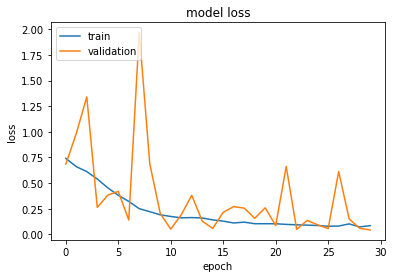

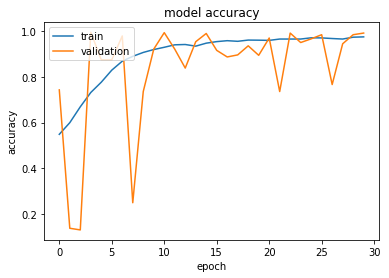

In [56]:
def plot_hist(history):
    #Ploting Loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    #Plotting Accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    
# Ploting History
plot_hist(history)


**Testing our DNN model on the test data**

In [57]:
# Evalulating
err_cv, acc_cv = dnn.evaluate(cv_data,cv_labels)
print("DNN accuracy on CV dataset using word2vec: {}".format(acc_cv))

449/449 [==============================] - 0s 155us/step
DNN accuracy on CV dataset using word2vec: 0.9220489977728286


In [58]:
# Evalulating
err_test, acc_test = dnn.evaluate(test_data,test_labels)
print("DNN accuracy on test dataset using word2vec: {}".format(acc_test))

497/497 [==============================] - 0s 166us/step
DNN accuracy on test dataset using word2vec: 0.9275653924740536


**We achieve an overall accuracy of 92% on both test sets using the DNN combined with Word2Vec** 